In order to be able to run the simulations efficiently we coded all simulation code in C++. The code requires no external libraries and should be compilable with G++ 11.4.
To run the library one must go to the Simulations folder and compile the code into a dynamically linked library by running make.
The file cpp_routines.py should be imported to Python to run the routines. The current implementation only works for Linux systems.
For more details about how to use cpp_routines library please refer to API.txt in Simulations folder

For the analysis we use mostly standard Python packages. The two exceptions are *emcee* package we use for MCMC sampling and *corner* package we use for corner plots.

In [1]:
! cd Simulations; make

Making obj directory...
mkdir obj
mkdir obj/core
Compiling run.cpp...
g++  -c -O3 -I.  -ICore  -IStrategies  -ISuppl  -o obj/run.o run.cpp
Compiling routines_lib.cpp...
g++  -c -O3 -I.  -ICore  -IStrategies  -ISuppl  -fpic -o obj/routines_lib.o routines_lib.cpp
g++  -o run  obj/run.o -lm
g++  -shared -o routines_lib.so  obj/routines_lib.o -lm


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

import os
import sys

import os
if not os.path.exists('Plots'):
    os.mkdir('Plots')

#Loading simulation routines
os.environ['SIMULATION_ROUTINES_PATH'] = os.getcwd() + '/Simulations/'
sys.path.append('Simulations')
from cpp_routines import *
#Loading decision processing routines
from data_process import *
#Loading logisic regression analysis routines
from logit_analysis import *

# Transition table

Here we reproduce the required threshold for the number of remaining arm pulls table. The number 0 in the table indicates that no threshold was found and the exploration for such success and failure configuration should be continued indefinitely

In [3]:
trans_table = optimal_transition_table(10, 10, 2000, prior=(1, 1))
print(trans_table)

[[   1    1    1    1    1    1    1    1    1    1]
 [   0    1    1    1    1    1    1    1    1    1]
 [   0   12    1    1    1    1    1    1    1    1]
 [   0   39    5    1    1    1    1    1    1    1]
 [   0   94   10    3    1    1    1    1    1    1]
 [   0  190   19    6    3    1    1    1    1    1]
 [   0  344   30   10    5    2    1    1    1    1]
 [   0  578   45   14    7    4    2    1    1    1]
 [   0  915   63   20    9    5    3    2    1    1]
 [   0 1385   86   27   13    7    5    3    2    1]]


# Optimal policy simulation

In [4]:
run_time = 100
number_of_runs = 10000
button_prior = (1, 1)
policy_prior = (1, 1)

# button = Button('Bernoulli', prior=(1, 1))
button = Button('Bernoulli', prior=button_prior)
policy = Policy('Bernoulli', prior=policy_prior)
# policy = Policy('Truncated', truncation=0.9)
# policy = Policy('Difference', difference=4)

trial_record = record_full_trials(run_time, number_of_runs, button, policy)

#Analysing decisions with data_process routines
processed_decisions = Decision_Process(trial_record)

In [5]:
num_buttons_simulation, top_button_to_all_simulation = processed_decisions.analyze_largest_contribution()
decisions_aggregated = aggregate_wins_fails(processed_decisions.get_decisions(wins_more_fails=False))

The average number of buttons explored is 8.7291
The average reward received is 85.5526
Out of 10000 subjects in total 9769 subjects (or 97.69%) got the largest contribution from the last button
The average contribution of the button with the largest contribution is 85.78 %


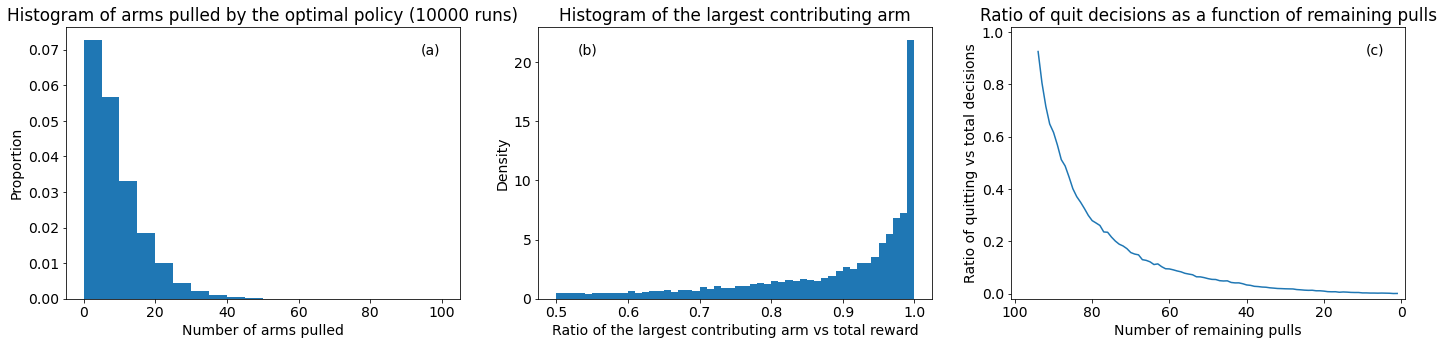

In [6]:
plt.rcParams.update({'font.size': 14})
fig = plt.figure(figsize=(24,5))

ax = fig.add_subplot(131)
ax.set_title("Histogram of arms pulled by the optimal policy (10000 runs)")
ax.annotate("(a)", xy=(.9, .9), xycoords='axes fraction')
ax.set_xlabel("Number of arms pulled")
ax.set_ylabel("Proportion")
ax.hist(num_buttons_simulation, density=True, bins=20, range=(0, 100))

ax = fig.add_subplot(132)
ax.set_title("Histogram of the largest contributing arm")
ax.annotate("(b)", xy=(.1, .9), xycoords='axes fraction')
ax.set_xlabel("Ratio of the largest contributing arm vs total reward")
ax.set_ylabel("Density")
ax.hist(top_button_to_all_simulation, density=True, bins=50, range=(0.5,1))

ax = fig.add_subplot(133)
ax.set_title("Ratio of quit decisions as a function of remaining pulls")
ax.annotate("(c)", xy=(.9, .9), xycoords='axes fraction')
ax.set_xlabel("Number of remaining pulls")
ax.set_xlim((-1,101))
ax.set_xticks(np.linspace(0, 100, num=6))
ax.set_ylabel("Ratio of quitting vs total decisions")
ax.set_ylim((-0.02,1.02))
ax.plot(decisions_aggregated[:,0], decisions_aggregated[:,1]/(decisions_aggregated[:,1]+decisions_aggregated[:,2]))
ax.invert_xaxis()

plt.savefig('Plots/model_sim.png',dpi=120,bbox_inches='tight')
plt.show()

# Optimal policy with probability truncation simulation

We start by investigating the behavior of the optimal strategy on three groups with probabilities capped at 0.9, 0.8 and 0.7

In [7]:
run_time = 100
number_of_runs = 10000
# button = Button('Bernoulli', prior=(1, 1))
# button = Button('Truncated', truncation=0.8)
policy = Policy('Bernoulli', prior=(1, 1))
# policy = Policy('Truncated', truncation=0.9)
# policy = Policy('Difference', difference=4)
# policy = Policy('Random', switch_probability=0.5)

truncations = [0.9, 0.8, 0.7]
plot_legend = ['Truncation ' + str(truncation) for truncation in truncations]

trial_records = []
decisions_processed = []

for trunc in truncations:
    button = Button('Truncated', truncation=trunc)
    trial_record = record_full_trials(run_time, number_of_runs, button, policy)
    trial_records.append(trial_record)
    decisions_processed.append(Decision_Process(trial_record))
    
total_process = Decision_Process(np.concatenate(trial_records))

In [8]:
for truncation, trunc_process in zip(truncations, decisions_processed):
    print('Fitting the optimal policy for the cap p = %.1lf' % truncation)
    decisions_to_use = trunc_process.get_decisions()
    print('Total number of stay decisions is %d' % np.count_nonzero(decisions_to_use[:,2] == 0))
    print('Total number of leave decisions is %d' % np.count_nonzero(decisions_to_use[:,2] == 1))
    print('')
    
    selected_decisions, cross_validation = select_n_decisions(decisions_to_use, 100000, 100000, return_cross=True)
    
    regression = BinaryLogisticRegression(selected_decisions[0], selected_decisions[1])
    regression.fit()
    
    print('\nRunning self-validation:')
    regression.cross_validation(regression.first_class, regression.second_class)
    print('\nRunning cross-validation:')
    regression.cross_validation(cross_validation[0], cross_validation[1]);
    print('')

Fitting the optimal policy for the cap p = 0.9
Total number of stay decisions is 533036
Total number of leave decisions is 173605

MLE estimates:
Plane normal vector: [-1.03861049  3.17286766  0.05025719]
Plane intercept: -1.0405205780712397
MLE value: -15941.95425684092

MAP estimates:
Plane normal vector: [-1.0378229   3.16980498  0.05019222]
Plane intercept: -1.0361980863905043
MAP value: -15951.738125686676

Running self-validation:
Percentage of misidentified stay decisions: 3.44
Percentage of misidentified leave decisions: 1.78

Running cross-validation:
Percentage of misidentified stay decisions: 3.43
Percentage of misidentified leave decisions: 1.74

Fitting the optimal policy for the cap p = 0.8
Total number of stay decisions is 313918
Total number of leave decisions is 332298

MLE estimates:
Plane normal vector: [-1.25520926  2.97574178  0.05170836]
Plane intercept: -0.7541579503524499
MLE value: -22221.91790889322

MAP estimates:
Plane normal vector: [-1.25460209  2.97373331

Now we analize the combined data from the three cap groups

In [9]:
decisions_to_use = total_process.get_decisions(wins_more_fails=False)

print('Total number of stay decisions is %d' % np.count_nonzero(decisions_to_use[:,2] == 0))
print('Total number of leave decisions is %d' % np.count_nonzero(decisions_to_use[:,2] == 1))

selected_decisions, cross_validation = select_n_decisions(decisions_to_use, 15000, 15000, return_cross=True)

regression = BinaryLogisticRegression(selected_decisions[0], selected_decisions[1])
regression.fit()
print('Running cross-validation:')
regression.cross_validation(cross_validation[0], cross_validation[1]);

Total number of stay decisions is 1004082
Total number of leave decisions is 988172
MLE estimates:
Plane normal vector: [-1.29883495  3.11837415  0.05295259]
Plane intercept: -0.7355870356182304
MLE value: -2969.488845259736

MAP estimates:
Plane normal vector: [-1.29358588  3.10096321  0.05263605]
Plane intercept: -0.7174812512686177
MAP value: -2979.104963498818
Running cross-validation:
Percentage of misidentified stay decisions: 4.00
Percentage of misidentified leave decisions: 2.23


100%|███████████████████████████████████████| 3000/3000 [01:08<00:00, 43.58it/s]


Autocorrelation times: [40.04854926 41.43046463 40.97018494 40.74736782]


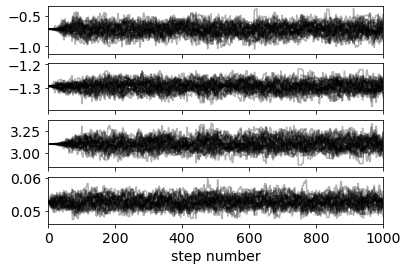

In [10]:
regression.run_mcmc(samples=3000)
regression.mcmc_diagnostic()

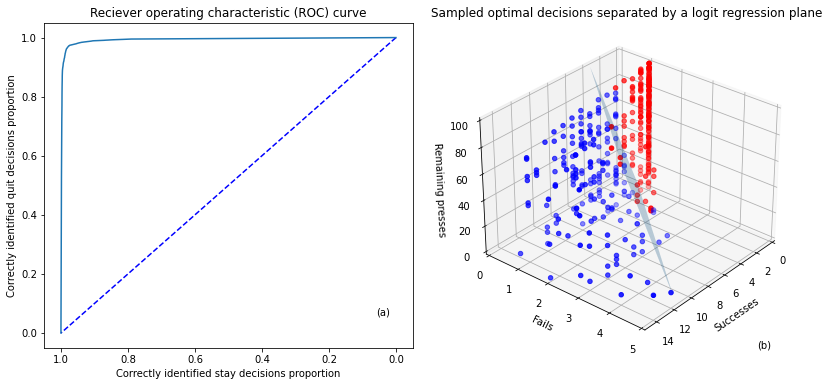

In [11]:
%matplotlib inline
plt.rcParams.update({'font.size': 10})
fig = plt.figure(figsize=(12,6))

ax = fig.add_subplot(121)
ax.annotate("(a)", xy=(.9, .1), xycoords='axes fraction')
plot_roc_frame(ax)
regression.construct_roc_curve(cross_validation[0], cross_validation[1], plot_curve=True, plot=ax);

ax = fig.add_subplot(122, projection='3d')
ax.annotate("(b)", xy=(.9, .0), xycoords='axes fraction')
ax.set_title("Sampled optimal decisions separated by a logit regression plane")
plot_regression(selected_decisions,
                regression,
                max_wins = 15,
                max_fails = 5,
                n_plot = 200,
#                 transition_table=trans_table,
                plot=ax);
ax.view_init(30, 40)

plt.tight_layout(pad=3.0)
plt.savefig("Plots/optimal_roc_curve_regression.png",dpi=120)
plt.show()